# Transformer GPT-Style Architecture - NumPy Implementation

**Author:** Muhammad Luthfi Attaqi (22/496427/TK/54387) 

## Overview

Implementation of a decoder-only Transformer (GPT-style) from scratch using only NumPy.

### Core Components
1. Token Embedding
2. Positional Encoding (Sinusoidal)
3. Scaled Dot-Product Attention
4. Multi-Head Attention
5. Feed-Forward Network
6. Layer Normalization + Residual Connections
7. Causal Masking
8. Output Layer

### Bonus Features
- RoPE (Rotary Position Embedding)
- Weight Tying
- Attention Visualization

## 1. Install Dependencies

Run this cell first to install required packages:

In [66]:
!pip install numpy matplotlib seaborn


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## 2. Import Libraries

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 3. Helper Functions

### Softmax Function

Formula: $$\text{softmax}(x_i) = \frac{e^{x_i}}{\sum_{j} e^{x_j}}$$

In [68]:
def softmax(x, axis=-1):
    # Numerical stability by subtracting max
    x_max = np.max(x, axis=axis, keepdims=True)
    exp_x = np.exp(x - x_max)
    return exp_x / np.sum(exp_x, axis=axis, keepdims=True)

### Layer Normalization

Formula: $$\text{LayerNorm}(x) = \gamma \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta$$

In [69]:
def layer_norm(x, gamma, beta, eps=1e-5):
    mean = np.mean(x, axis=-1, keepdims=True)
    var = np.var(x, axis=-1, keepdims=True)
    x_norm = (x - mean) / np.sqrt(var + eps)
    return gamma * x_norm + beta

### GELU Activation

Formula: $$\text{GELU}(x) = 0.5x\left(1 + \tanh\left[\sqrt{\frac{2}{\pi}}(x + 0.044715x^3)\right]\right)$$

In [70]:
def gelu(x):
    # Approximation of GELU activation
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * x**3)))

## 4. Token Embedding

Converts token indices to dense vector representations.

**Input:** Token indices `[batch, seq_len]`  
**Output:** Embeddings `[batch, seq_len, d_model]`

In [71]:
class TokenEmbedding:
    def __init__(self, vocab_size, d_model):
        self.vocab_size = vocab_size
        self.d_model = d_model
        # Xavier initialization
        self.weight = np.random.randn(vocab_size, d_model) * np.sqrt(2.0 / (vocab_size + d_model))
    
    def forward(self, x):
        # Lookup embedding for each token
        return self.weight[x]

## 5. Positional Encoding

### 5.1 Sinusoidal Positional Encoding

Formula:
$$PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$
$$PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{model}}}\right)$$

Where:
- `pos` = position in sequence
- `i` = dimension index
- `d_model` = embedding dimension

In [72]:
class PositionalEncoding:
    def __init__(self, d_model, max_len=5000):
        self.d_model = d_model
        
        # Create positional encoding matrix
        pe = np.zeros((max_len, d_model))
        position = np.arange(0, max_len)[:, np.newaxis]
        div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        
        # Apply sin to even indices
        pe[:, 0::2] = np.sin(position * div_term)
        # Apply cos to odd indices
        pe[:, 1::2] = np.cos(position * div_term)
        
        self.pe = pe
    
    def forward(self, x):
        # Add positional encoding to embeddings
        seq_len = x.shape[1]
        return x + self.pe[:seq_len, :]

### 5.2 RoPE - Rotary Position Embedding (BONUS)

Alternative positional encoding that rotates embedding vectors.

**Benefits:**
- Better relative position modeling
- Used in modern LLMs (LLaMA, GPT-NeoX)

In [73]:
class RotaryPositionalEmbedding:
    def __init__(self, d_model, max_len=5000):
        assert d_model % 2 == 0, "d_model must be even for RoPE"
        self.d_model = d_model
        
        # Compute rotation frequencies
        inv_freq = 1.0 / (10000 ** (np.arange(0, d_model, 2) / d_model))
        position = np.arange(max_len)
        freqs = np.outer(position, inv_freq)
        
        # Cache cosine and sine values
        self.cos_cached = np.cos(freqs)
        self.sin_cached = np.sin(freqs)
    
    def rotate_half(self, x):
        # Rotate by swapping pairs and negating
        x1 = x[..., ::2]
        x2 = x[..., 1::2]
        result = np.zeros_like(x)
        result[..., ::2] = -x2
        result[..., 1::2] = x1
        return result
    
    def forward(self, x):
        # Apply rotary position embedding
        seq_len = x.shape[1]
        cos = np.repeat(self.cos_cached[:seq_len, :], 2, axis=-1)
        sin = np.repeat(self.sin_cached[:seq_len, :], 2, axis=-1)
        return x * cos + self.rotate_half(x) * sin

## 6. Attention Mechanisms

### 6.1 Scaled Dot-Product Attention

Formula:
$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

Where:
- `Q` = Query matrix
- `K` = Key matrix
- `V` = Value matrix
- `d_k` = dimension of key vectors

In [74]:
def scaled_dot_product_attention(Q, K, V, mask=None):
    d_k = Q.shape[-1]
    
    # Compute attention scores: Q @ K^T / sqrt(d_k)
    scores = np.matmul(Q, K.transpose(0, 2, 1)) / np.sqrt(d_k)
    
    # Apply mask if provided (for causal attention)
    if mask is not None:
        scores = scores + mask
    
    # Get attention weights via softmax
    attention_weights = softmax(scores, axis=-1)
    
    # Apply attention to values
    output = np.matmul(attention_weights, V)
    
    return output, attention_weights

### 6.2 Multi-Head Attention

Formula:
$$\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, ..., \text{head}_h)W^O$$

$$\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)$$

Where:
- `h` = number of heads
- `W^Q, W^K, W^V` = projection matrices
- `W^O` = output projection matrix

In [75]:
class MultiHeadAttention:
    def __init__(self, d_model, num_heads):
        assert d_model % num_heads == 0

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        # Initialize projection weights
        self.W_q = np.random.randn(d_model, d_model) * np.sqrt(2.0 / d_model)
        self.W_k = np.random.randn(d_model, d_model) * np.sqrt(2.0 / d_model)
        self.W_v = np.random.randn(d_model, d_model) * np.sqrt(2.0 / d_model)
        self.W_o = np.random.randn(d_model, d_model) * np.sqrt(2.0 / d_model)

    def split_heads(self, x):
        # Reshape to separate heads: [batch, seq_len, num_heads, d_k]
        batch_size, seq_len, _ = x.shape
        x = x.reshape(batch_size, seq_len, self.num_heads, self.d_k)
        # Transpose to [batch, num_heads, seq_len, d_k]
        return x.transpose(0, 2, 1, 3)

    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.shape
        
        # Linear projections
        Q = np.matmul(x, self.W_q)
        K = np.matmul(x, self.W_k)
        V = np.matmul(x, self.W_v)

        # Split into heads
        Q_heads = self.split_heads(Q)
        K_heads = self.split_heads(K)
        V_heads = self.split_heads(V)
        
        # Apply attention. The `scaled_dot_product_attention` function must now handle the batch and heads dimension
        attn_output, attn_weights = scaled_dot_product_attention(Q_heads, K_heads, V_heads, mask)
        
        # Reshape attention output back
        attn_output = attn_output.transpose(0, 2, 1, 3).reshape(batch_size, seq_len, self.d_model)
        
        # Final projection
        output = np.matmul(attn_output, self.W_o)
        
        return output, attn_weights

In [76]:
def scaled_dot_product_attention(Q, K, V, mask=None):
    d_k = Q.shape[-1]
    
    # Compute attention scores: Q @ K^T / sqrt(d_k)
    scores = np.matmul(Q, K.transpose(0, 1, 3, 2)) / np.sqrt(d_k)  # Note the transpose axes
    
    # Apply mask if provided (for causal attention)
    if mask is not None:
        scores = scores + mask  # Broadcasting will apply this to each head/batch
    
    # Get attention weights via softmax
    attention_weights = softmax(scores, axis=-1)
    
    # Apply attention to values
    output = np.matmul(attention_weights, V)
    
    return output, attention_weights

## 7. Feed-Forward Network

Formula:
$$\text{FFN}(x) = \text{GELU}(xW_1 + b_1)W_2 + b_2$$

Two-layer network with GELU activation.

In [77]:
class FeedForwardNetwork:
    def __init__(self, d_model, d_ff):
        # Initialize two linear layers
        self.W1 = np.random.randn(d_model, d_ff) * np.sqrt(2.0 / d_model)
        self.b1 = np.zeros(d_ff)
        self.W2 = np.random.randn(d_ff, d_model) * np.sqrt(2.0 / d_ff)
        self.b2 = np.zeros(d_model)
    
    def forward(self, x):
        # First layer with GELU activation
        hidden = gelu(np.matmul(x, self.W1) + self.b1)
        # Second layer
        output = np.matmul(hidden, self.W2) + self.b2
        return output

## 8. Causal Masking

Prevents attention to future positions (autoregressive property).

**Formula:**
```
mask[i, j] = 0     if j <= i  (can attend)
mask[i, j] = -∞    if j > i   (cannot attend)
```

**Example (5x5):**
```
Position 0: [✓ ✗ ✗ ✗ ✗]  (can only see position 0)
Position 1: [✓ ✓ ✗ ✗ ✗]  (can see positions 0-1)
Position 2: [✓ ✓ ✓ ✗ ✗]  (can see positions 0-2)
Position 3: [✓ ✓ ✓ ✓ ✗]  (can see positions 0-3)
Position 4: [✓ ✓ ✓ ✓ ✓]  (can see all positions)
```

In [78]:
def create_causal_mask(seq_len):
    # Upper triangular matrix with -inf (blocks future tokens)
    mask = np.triu(np.ones((seq_len, seq_len)), k=1) * -1e9
    return mask

## 9. Decoder Block

Combines all components with Pre-Layer Normalization:

```
x = x + MultiHeadAttention(LayerNorm(x))
x = x + FFN(LayerNorm(x))
```

In [79]:
class DecoderBlock:
    def __init__(self, d_model, num_heads, d_ff):
        self.attention = MultiHeadAttention(d_model, num_heads)
        self.ffn = FeedForwardNetwork(d_model, d_ff)
        
        # Layer normalization parameters
        self.gamma1 = np.ones(d_model)
        self.beta1 = np.zeros(d_model)
        self.gamma2 = np.ones(d_model)
        self.beta2 = np.zeros(d_model)
    
    def forward(self, x, mask=None):
        # Pre-norm Multi-Head Attention + Residual
        norm_x = layer_norm(x, self.gamma1, self.beta1)
        attn_output, attn_weights = self.attention.forward(norm_x, mask)
        x = x + attn_output
        
        # Pre-norm FFN + Residual
        norm_x = layer_norm(x, self.gamma2, self.beta2)
        ffn_output = self.ffn.forward(norm_x)
        x = x + ffn_output
        
        return x, attn_weights

## 10. Complete Transformer Model

**Architecture:**
```
Input Tokens
    ↓
Token Embedding + Positional Encoding
    ↓
Decoder Blocks (× N layers)
    ↓
Layer Norm
    ↓
Output Projection → Logits [batch, seq_len, vocab_size]
    ↓
Softmax (last position) → Next Token Probabilities
```

In [80]:
class GPTTransformer:
    def __init__(self, vocab_size, d_model, num_heads, num_layers, d_ff, 
                 max_len=512, use_rope=False, weight_tying=False):
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.use_rope = use_rope
        self.weight_tying = weight_tying
        
        # Token embedding
        self.token_embedding = TokenEmbedding(vocab_size, d_model)
        
        # Positional encoding (choose between standard or RoPE)
        if use_rope:
            self.positional_encoding = RotaryPositionalEmbedding(d_model, max_len)
        else:
            self.positional_encoding = PositionalEncoding(d_model, max_len)
        
        # Stack of decoder blocks
        self.decoder_blocks = [
            DecoderBlock(d_model, num_heads, d_ff) for _ in range(num_layers)
        ]
        
        # Final layer norm
        self.gamma_final = np.ones(d_model)
        self.beta_final = np.zeros(d_model)
        
        # Output projection (with optional weight tying)
        if weight_tying:
            self.output_projection = self.token_embedding.weight.T
        else:
            self.output_projection = np.random.randn(d_model, vocab_size) * np.sqrt(2.0 / d_model)
    
    def forward(self, x):
        # x: token indices [batch, seq_len]
        # Returns: logits [batch, seq_len, vocab_size],
        #          next_token_probs [batch, vocab_size],
        #          attention_weights (list of attention matrices)
        
        batch_size, seq_len = x.shape
        
        # Embedding + positional encoding
        embeddings = self.token_embedding.forward(x)
        x = self.positional_encoding.forward(embeddings)
        
        # Create causal mask
        mask = create_causal_mask(seq_len)
        
        # Pass through decoder blocks
        all_attention_weights = []
        for decoder_block in self.decoder_blocks:
            x, attn_weights = decoder_block.forward(x, mask)
            all_attention_weights.append(attn_weights)
        
        # Final layer norm
        x = layer_norm(x, self.gamma_final, self.beta_final)
        
        # Project to vocabulary size
        logits = np.matmul(x, self.output_projection)
        
        # Get next token probabilities (softmax of last position)
        last_token_logits = logits[:, -1, :]
        next_token_probs = softmax(last_token_logits, axis=-1)
        
        return logits, next_token_probs, all_attention_weights

## 11. Attention Visualization (BONUS)

In [81]:
def visualize_attention(attention_weights, layer_idx=0, head_idx=0):
    # Visualize single attention head as heatmap
    attn = attention_weights[layer_idx][0, head_idx, :, :]
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(attn, cmap='viridis', annot=True, fmt='.2f', cbar=True)
    plt.title(f'Attention Weights - Layer {layer_idx}, Head {head_idx}')
    plt.xlabel('Key Position')
    plt.ylabel('Query Position')
    plt.tight_layout()
    plt.show()


def plot_attention_statistics(attention_weights):
    # Plot average attention across all heads for each layer
    num_layers = len(attention_weights)
    
    fig, axes = plt.subplots(1, num_layers, figsize=(5 * num_layers, 4))
    if num_layers == 1:
        axes = [axes]
    
    for layer_idx, attn in enumerate(attention_weights):
        avg_attn = np.mean(attn, axis=(0, 1))
        
        sns.heatmap(avg_attn, cmap='Blues', cbar=True, ax=axes[layer_idx])
        axes[layer_idx].set_title(f'Layer {layer_idx}\nAvg Attention')
        axes[layer_idx].set_xlabel('Key')
        axes[layer_idx].set_ylabel('Query')
    
    plt.tight_layout()
    plt.show()

## 12. Simple Test Function

In [82]:
def test_transformer():
    # Configuration
    vocab_size = 1000
    d_model = 512
    num_heads = 8
    num_layers = 6
    d_ff = 2048
    seq_len = 10
    batch_size = 2
    
    print("="*70)
    print("TRANSFORMER GPT-STYLE TESTING")
    print("="*70)
    print(f"\nConfiguration:")
    print(f"  Vocabulary Size: {vocab_size}")
    print(f"  Model Dimension: {d_model}")
    print(f"  Number of Heads: {num_heads}")
    print(f"  Number of Layers: {num_layers}")
    print(f"  FFN Dimension: {d_ff}")
    print(f"  Sequence Length: {seq_len}")
    print(f"  Batch Size: {batch_size}")
    
    # Create models
    print("\n" + "="*70)
    print("=== Testing Standard Transformer ===")
    model_standard = GPTTransformer(vocab_size, d_model, num_heads, num_layers, d_ff,
                                   use_rope=False, weight_tying=False)
    
    print("\n=== Testing RoPE Transformer ===")
    model_rope = GPTTransformer(vocab_size, d_model, num_heads, num_layers, d_ff,
                               use_rope=True, weight_tying=False)
    
    print("\n=== Testing Weight-Tied Transformer ===")
    model_tied = GPTTransformer(vocab_size, d_model, num_heads, num_layers, d_ff,
                               use_rope=False, weight_tying=True)
    
    # Input tokens (simple tokenization as list of numbers)
    tokens = np.random.randint(0, vocab_size, (batch_size, seq_len))
    print(f"\nInput tokens:\n{tokens}")
    
    # Test each model
    for model_name, model in [("Standard", model_standard), 
                               ("RoPE", model_rope), 
                               ("Weight-Tied", model_tied)]:
        print("\n" + "="*70)
        print(f"--- {model_name} Model ---")
        
        logits, next_token_probs, attention_weights = model.forward(tokens)
        
        print(f"Input tokens shape: {tokens.shape}")
        print(f"Logits shape: {logits.shape}")
        print(f"Next token probabilities shape: {next_token_probs.shape}")
        print(f"Number of attention weight matrices: {len(attention_weights)}")
        print(f"Attention weights shape per layer: {attention_weights[0].shape}")
        print(f"Sum of next token probabilities: {np.sum(next_token_probs, axis=-1)}")
        print(f"  (should be ~1.0 for each sample)")
        
        # Top-5 predicted tokens
        for b in range(batch_size):
            top_5 = np.argsort(next_token_probs[b])[-5:][::-1]
            print(f"\n  Sample {b} - Top 5 predicted tokens:")
            for i, token_id in enumerate(top_5, 1):
                print(f"    {i}. Token {token_id}: {next_token_probs[b, token_id]:.4f}")
        
        if model_name == "Weight-Tied":
            print(f"\nWeight tying check:")
            print(f"  Embedding weight shape: {model.token_embedding.weight.shape}")
            print(f"  Output projection shape: {model.output_projection.shape}")
            print(f"  Weight tying enabled: {model.weight_tying}")
    
    # Visualization demo
    print("\n" + "="*70)
    print("=== Attention Visualization Demo ===")
    print("\nGenerating attention heatmap...")
    visualize_attention(attention_weights, layer_idx=0, head_idx=0)
    
    print("\nGenerating attention statistics...")
    plot_attention_statistics(attention_weights)
    
    print("\n" + "="*70)
    print("ALL TESTS COMPLETED SUCCESSFULLY!")
    print("="*70)
    
    return True

## 13. Run Tests

TRANSFORMER GPT-STYLE TESTING

Configuration:
  Vocabulary Size: 1000
  Model Dimension: 512
  Number of Heads: 8
  Number of Layers: 6
  FFN Dimension: 2048
  Sequence Length: 10
  Batch Size: 2

=== Testing Standard Transformer ===

=== Testing RoPE Transformer ===

=== Testing Weight-Tied Transformer ===

Input tokens:
[[972 798 143  64 397 111  61 554 130 650]
 [342  33 567 658 329 555 393 435 725 475]]

--- Standard Model ---
Input tokens shape: (2, 10)
Logits shape: (2, 10, 1000)
Next token probabilities shape: (2, 1000)
Number of attention weight matrices: 6
Attention weights shape per layer: (2, 8, 10, 10)
Sum of next token probabilities: [1. 1.]
  (should be ~1.0 for each sample)

  Sample 0 - Top 5 predicted tokens:
    1. Token 321: 0.0448
    2. Token 30: 0.0294
    3. Token 366: 0.0192
    4. Token 13: 0.0156
    5. Token 633: 0.0149

  Sample 1 - Top 5 predicted tokens:
    1. Token 321: 0.0467
    2. Token 30: 0.0312
    3. Token 366: 0.0182
    4. Token 13: 0.0161
    5

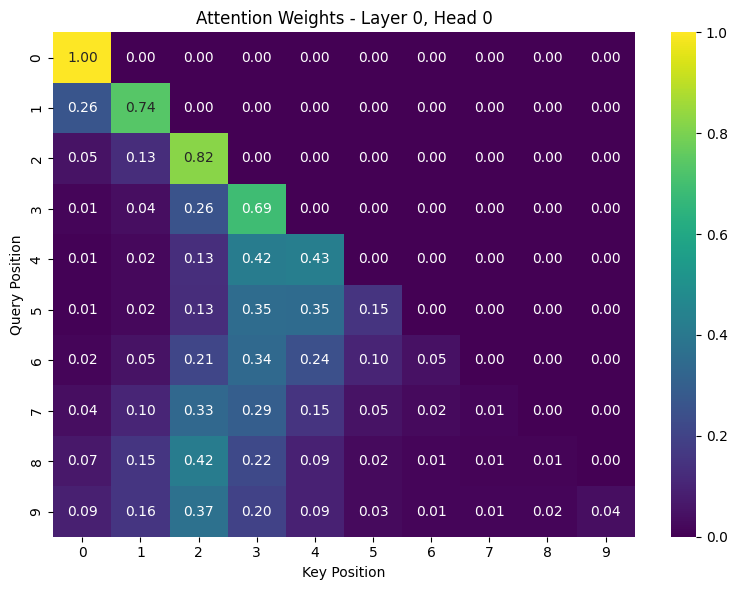


Generating attention statistics...


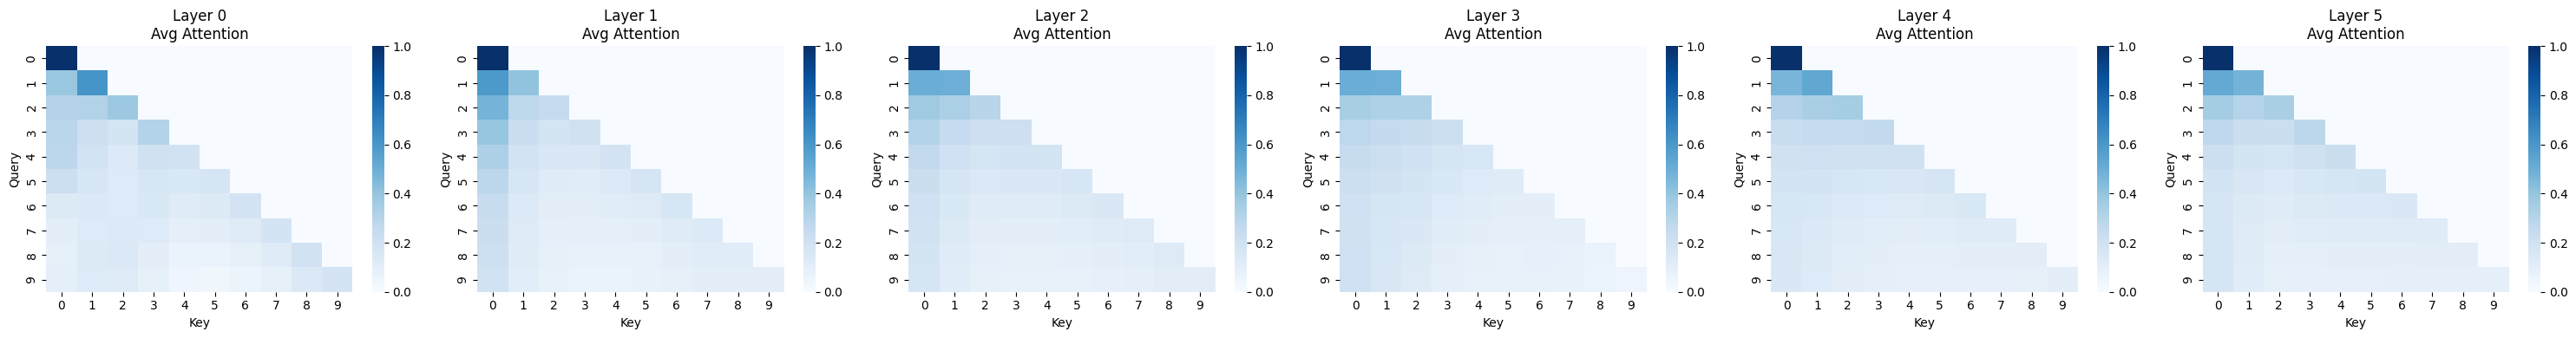


ALL TESTS COMPLETED SUCCESSFULLY!


True

In [83]:
# Run the test
test_transformer()

## Summary

### Core Components Implemented:
1. **Token Embedding** - Converts tokens to vectors
2. **Positional Encoding** - Adds position information (Sinusoidal)
3. **Scaled Dot-Product Attention** - Core attention mechanism
4. **Multi-Head Attention** - Parallel attention heads
5. **Feed-Forward Network** - Two-layer MLP with GELU
6. **Layer Normalization + Residual Connections** - Pre-LN architecture
7. **Causal Masking** - Prevents future token access
8. **Output Layer** - Projects to vocabulary and computes probabilities

### Bonus Features:
- **RoPE** - Rotary Position Embedding (modern alternative)
- **Weight Tying** - Shared embedding/output weights
- **Attention Visualization** - Heatmaps and statistics

### Model Input/Output:
- **Input:** Token indices `[batch, seq_len]` (simple list of numbers)
- **Output:** 
  - Logits `[batch, seq_len, vocab_size]`
  - Next token probabilities `[batch, vocab_size]`
  - Attention weights (for visualization)